In [1]:
import os

os.chdir('CoTuning')

In [2]:
import argparse
import os
from time import time

import numpy as np
import torch
import torch.nn as nn
import torchvision
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader
from torchvision import datasets
from tqdm import tqdm

from module.backbone import ResNet50_F, ResNet50_C
from module.relationship_learning import relationship_learning
from utils.transforms import get_transforms
from utils.tools import AccuracyMeter, TenCropsTest

In [8]:
def get_configs():
    parser = argparse.ArgumentParser(
        description='Pytorch Co-Tuning Training')

    # train
    parser.add_argument('--gpu', default='0', type=int,
                        help='GPU num for training')
    parser.add_argument('--seed', type=int, default=2020)

    # dataset
    parser.add_argument('--dataset', default="cub",
                        type=str, help='Name of dataset')
    parser.add_argument('--data_path', default="/data/finetune/cub200",
                        type=str, help='Path of dataset')
    parser.add_argument('--class_num', default=200,
                        type=int, help='number of classes')
    parser.add_argument('--num_workers', default=2, type=int,
                        help='Num of workers used in dataloading')

    parser.add_argument('--save_path', default='features', type=str,
                        help='Path of pre-computed relationship')

    configs = parser.parse_args([])

    return configs

In [9]:
configs = get_configs()

In [9]:
data_transforms = get_transforms(resize_size=256, crop_size=224)

determin_train_dataset = datasets.ImageFolder(
    os.path.join(configs.data_path, 'train'),
    transform=data_transforms['val'])
val_dataset = datasets.ImageFolder(
    os.path.join(configs.data_path, 'test'),
    transform=data_transforms['val'])

determin_train_loader = DataLoader(determin_train_dataset, batch_size=48, shuffle=False,
                                   num_workers=configs.num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=48, shuffle=False,
                        num_workers=configs.num_workers, pin_memory=True)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.f_net = ResNet50_F(pretrained=True)
        self.c_net = ResNet50_C(pretrained=True)

    def forward(self, x):
        feature = self.f_net(x)
        out_1 = self.c_net(feature)

        return out_1, feature

net = Net().cuda()

In [11]:
def get_feature(loader):
    idx = 0
    labels_list = []
    features_list = []
    outputs_list = []

    for inputs, labels in tqdm(loader):
        net.eval()
        labels_list.append(labels)
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs, features = net(inputs)
        outputs = outputs.detach().cpu().numpy()
        features = features.detach().cpu().numpy()
        outputs_list.append(outputs)
        features_list.append(features)

    all_labels = np.concatenate(labels_list, 0)
    all_outputs = np.concatenate(outputs_list, 0)
    all_features = np.concatenate(features_list, 0)

    return all_outputs, all_labels, all_features

train_outputs, train_labels, train_features = get_feature(determin_train_loader)
val_outputs, val_labels, val_features = get_feature(val_loader)
relationship = relationship_learning(train_outputs, train_labels,
                                     val_outputs, val_labels)

if not os.path.isdir(f'features_{configs.dataset}'):
    os.mkdir(f'features_{configs.dataset}')

np.save(f'features_{configs.dataset}/relationship.npy', relationship)
np.save(f'features_{configs.dataset}/features.npy', train_features)
np.save(f'features_{configs.dataset}/targets.npy', train_labels)

  0%|                                                                                                  | 0/125 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
  0%|                                                                                                  | 0/121 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:19<00:00,  6.07it/s]
/home/liuyong/miniconda3/envs/torch/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of i

calibrating, 0.5444937348365784


In [12]:
rl = torch.from_numpy(np.load(f'features_{configs.dataset}/relationship.npy'))
rl.shape # C_t x C_s

torch.Size([200, 1000])

In [13]:
rl.sum(axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

In [14]:
# https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
# http://www.vision.caltech.edu/visipedia/CUB-200.html
val, idx = rl.max(dim=1)
idx

tensor([146, 146, 146,  91, 145,  20,  80, 137,  18,  18,  20, 136,  18,  14,
         14,  90,  12,  95,  16,  11,  18,  82,  22, 137,  93,  91,  96,  13,
         18,  18,  16,  17,  16,  10,  12,  94,  12,  16,  16,  16, 912,  92,
         16, 128, 146,  97,  11,  11,  18, 137,  98, 137,  98,  14,  11,  12,
         18,  18,  99,  99, 143, 146,  81, 146, 143, 146,  94,  94,  94,  94,
        146, 146,  17,  17,  92,  13,  16,  16,  93,  95, 138,  15,  92, 146,
         10,  98,  97,  83,  97,  98,  17,  21,  17,  19,  15,  11,  15,  11,
         95, 144, 144,  16,  16, 140,  82,  22,  23,  23,  15, 135,  19,  19,
         10,  85,  13,  12,  86,  10,  12,  12,  13,  13,  12,  10,  12,  10,
         12,  16,  12,  10,  12,  16,  24,  84, 139,  15,  91,  18,  90,  12,
        143, 131, 143, 143, 143, 132,  16,  16,  12,  12, 134,  15,  19,  16,
         13,  11,  11,  10,  19,  18,  11,  11,  11,  14,  10,  11,  11,  11,
         11,  16,  12,  11,  11, 133,  11,  11,  11,  16,  16,  

In [3]:
from LogME import LogME
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

logme = LogME(regression=False)

In [10]:
features = np.load(f'features_{configs.dataset}/features.npy')
targets = np.load(f'features_{configs.dataset}/targets.npy')

In [11]:
X_tsne = TSNE(n_components=2, random_state=33).fit_transform(features)

/home/liuyong/miniconda3/envs/torch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/liuyong/miniconda3/envs/torch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


([], [])

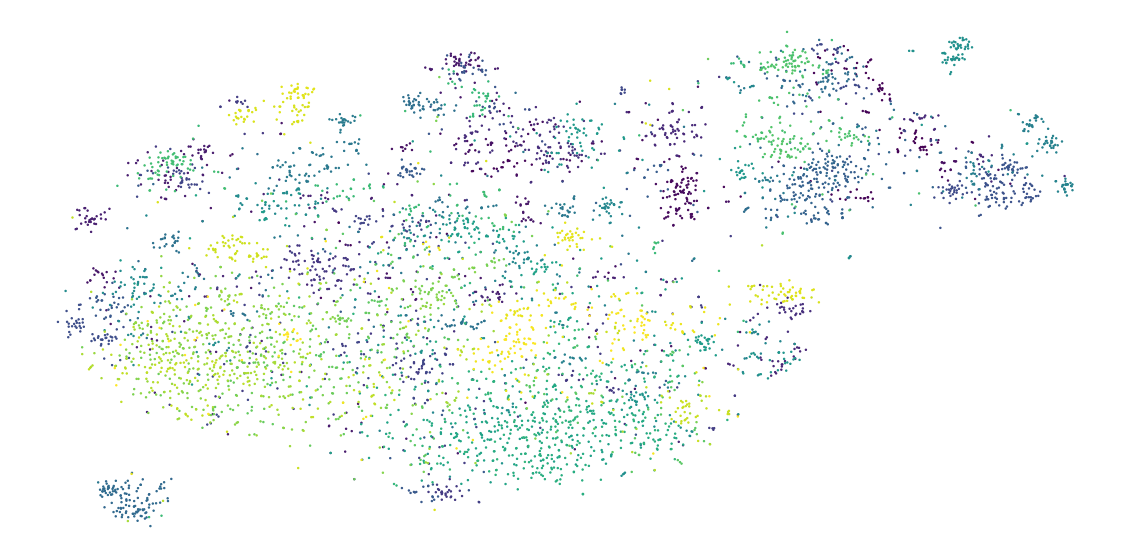

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=targets, s=2)
plt.xticks([])
plt.yticks([])

In [19]:
score = logme.fit(features, targets)
score

1.293951297787428

In [35]:
outputs_logme = features @ logme.ms.transpose()
preds_logme = torch.from_numpy(outputs_logme).softmax(dim=1)
preds_logme.shape

torch.Size([5994, 200])

In [28]:
dim=features.shape[1]
features = torch.from_numpy(features)
cov = features.T @ features
num_classes = max(targets)+1
As = []

for i in range(num_classes):
    A = logme.alphas[i] * torch.eye(dim) + logme.betas[i] * cov
    As.append(torch.linalg.inv(A))

varians = []
for i in range(num_classes):
    varian = torch.sum( (features * (features @ As[i]) ), dim=1) + 1/logme.betas[i]
    varians.append(varian)
varians_logme = torch.vstack(varians).T

varians_logme.shape # N x C

torch.Size([5994, 200])

In [36]:
np.save(f'features_{configs.dataset}/predictions.npy', preds_logme.numpy())
np.save(f'features_{configs.dataset}/variance.npy', varians_logme.numpy())